In [1]:
from numba import njit
import sklearn
import pandas as pd
from pandas.core.interchange.dataframe_protocol import DataFrame
import numpy as np
import scipy.optimize._minimize as minimize
from scipy.ndimage import label

In [2]:
def get_prob(A, x_i, x_j, pi, sigma_i, knn):
    if x_j in knn[x_i]:
        return np.exp(-(np.linalg.norm(A[x_i] - A[x_j])-pi)/sigma_i)
    return 0

In [3]:
def bin_search(arr, goal, epsilon):
    start, end = 0,len(arr)-1
    for i in range(end+1):
        middle = int((end - start)/2)
        if goal-epsilon <= arr[middle] <= goal+epsilon:
            return middle
        elif arr[middle] < goal-epsilon:
            start = middle+1
        else:
            end = middle-1
    return -1

In [4]:
def find_sigma_i(x_i, pi: float, k: int, Neighbours, A: np.ndarray):
    sig_i = np.linspace(0, 10, 100)
    goal = np.log2(k)
    def sig_exp(x_i, pi, sig, Neighbours, A):
        res = 0
        for x_ij in Neighbours:
            res += np.exp(-(np.linalg.norm(A[x_i]-A[x_ij])-pi)/sig)
        return res
    sigs = sig_exp(x_i, pi, sig_i, Neighbours, A)
    sig = bin_search(sigs, goal, 0.01)
    return sig_i[sig]
    

In [5]:
import numpy as np

def construct_knn(A: np.ndarray, k):
    """
    Constructs a k-NN matrix with distances.

    Parameters:
    - A (np.ndarray): Input data of shape (n_samples, n_features).
    - k (int): Number of nearest neighbors to find.

    Returns:
    - knn_indices (np.ndarray): k-NN indices matrix of shape (n_samples, k).
    - knn_dist_min (np.ndarray): Minimum nonzero distance for each sample.
    """
    n_samples = A.shape[0]
    knn_indices = np.zeros((n_samples, k), dtype=int)
    knn_dist_min = np.zeros((n_samples, 1), dtype=float)  # Should store float distances

    for i in range(n_samples):
        # Compute Euclidean distances
        distances = np.linalg.norm(A - A[i], axis=1)
        # Sort indices by distance, excluding the first (self)
        sorted_indices = np.argsort(distances)
        knn_indices[i] = sorted_indices[1:k+1]  # Skip self (index 0)
        knn_dist_min[i] = np.min(distances[sorted_indices[1:]])  # Min nonzero distance
    knn_map = {}
    knn_dist_map = {}
    for i in range(n_samples):
        knn_map[i] = set(knn_indices[i])
        knn_dist_map[i] = knn_dist_min[i]
    return knn_map, knn_indices, knn_dist_map


In [6]:
#input in as a pandas dataframe
def umap(data: pd.DataFrame, k: int, a,b):
    p_ij = {}
    data = data.copy().to_numpy()
    n_samples = data.shape[0]
    knn_map, knn_mat, knn_dist = construct_knn(data, k)
    for i in range(n_samples):
        for j in range(n_samples):
            if j == i:
                continue
            pi = knn_dist[i]
            sig = find_sigma_i(i, pi, k, knn_map[i], data)
            p_ij[(i,j)] = get_prob(data, i, j, pi, sig, knn_map)
    symmetric_knn_matrix = np.maximum(knn_mat, knn_mat.T)
    _, D = knn_mat.diagonalize()
    L = D - symmetric_knn_matrix
    return L

In [7]:
df = pd.read_csv("diabetes.csv")
data = pd.DataFrame({
    'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17],
    'B': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17 ],
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17],
})

nn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
print()

In [8]:
import numpy as np
from collections import Counter

In [9]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# expr = pd.read_csv(path + 'bartoschek_filtered_expr_rpkm.txt', sep='\t')
# print(expr.iloc[0:4,0:4])
# X_train = expr.values[:,0:(expr.shape[1]-1)]
# X_train = np.log(X_train + 1)
# n = X_train.shape[0]
# print("\nThis data set contains " + str(n) + " samples")
# y_train = expr.values[:,expr.shape[1]-1]
# print("\nDimensions of the  data set: ")
# print(X_train.shape, y_train.shape)

In [57]:
expr = pd.read_csv("diabetes.csv")
diabetic = expr[expr['Outcome'] == 1]
diabetic =diabetic.drop(['Outcome'], axis=1)
diabetic_x = diabetic.values[:, 0:(diabetic.shape[1] - 1)]
diabetic_x = np.log(diabetic_x + 1)
n = diabetic_x.shape[0]
print("\nThis data set contains " + str(n) + " samples")


This data set contains 268 samples


In [58]:
diabetic_y = diabetic.values[:, diabetic.shape[1] - 1]
print("\nDimensions of the  data set: ")
print(diabetic.shape, diabetic_y.shape)


Dimensions of the  data set: 
(268, 8) (268,)


In [61]:
non_diabetic = expr[expr['Outcome']==0]
non_diabetic =non_diabetic.drop(['Outcome'], axis=1)
non_diabetic_x = non_diabetic.values[:,0:(non_diabetic.shape[1]-1)]
non_diabetic_x = np.log(non_diabetic + 1)
non = non_diabetic_x.shape[0]
print("\nThis data set contains " + str(non) + " samples")
non_diabetic_y = non_diabetic.values[:,non_diabetic.shape[1]-1]
print("\nDimensions of the  data set: ")
print(non_diabetic_x.shape, non_diabetic_y.shape)


This data set contains 500 samples

Dimensions of the  data set: 
(500, 8) (500,)


In [60]:
dist_diabetes = np.square(euclidean_distances(diabetic_x, diabetic_x))
dist_non_diabetes = np.square(euclidean_distances(non_diabetic_x, non_diabetic_x))
dist_non_diabetes[0:4, 0:4]

array([[ 0.        , 20.95428609, 12.89879364, 32.35319618],
       [20.95428609,  0.        , 32.2528324 , 51.63372662],
       [12.89879364, 32.2528324 ,  0.        , 19.10921109],
       [32.35319618, 51.63372662, 19.10921109,  0.        ]])

In [62]:
def prob_high_dim(sigma, dist_row, dist):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    exp_distance = np.exp(-dist[dist_row] / (2*sigma**2))
    exp_distance[dist_row] = 0
    prob_not_symmetr = exp_distance / np.sum(exp_distance)
    #prob_symmetr = (prob_not_symmetr + prob_not_symmetr.T) / (2*n_samples)
    return prob_not_symmetr

def perplexity(prob):
    """
    Compute perplexity (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, -np.sum([p*np.log2(p) for p in prob if p!=0]))

In [63]:
def sigma_binary_search(perp_of_sigma, fixed_perplexity):
    """
    Solve equation perp_of_sigma(sigma) = fixed_perplexity 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if perp_of_sigma(approx_sigma) < fixed_perplexity:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_perplexity - perp_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

In [64]:
PERPLEXITY = 30
prob_diabetes = np.zeros((n,n))
sigma_array_diabetic = []
for dist_row in range(n):
    func_diabetes = lambda sigma: perplexity(prob_high_dim(sigma, dist_row, dist_diabetes))
    binary_search_result = sigma_binary_search(func_diabetes, PERPLEXITY)
    prob_diabetes[dist_row] = prob_high_dim(binary_search_result, dist_row, dist_diabetes)
    sigma_array_diabetic.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array_diabetic)))

Sigma binary search finished 100 of 268 cells
Sigma binary search finished 200 of 268 cells

Mean sigma = 0.5001737110650362


In [77]:
prob_non_diabetes = np.zeros((non,non))
sigma_array_non_diabetic = []
for dist_row in range(non):
    func_non_diabetes = lambda sigma: perplexity(prob_high_dim(sigma, dist_row, dist_non_diabetes))
    binary_search_result = sigma_binary_search(func_non_diabetes, PERPLEXITY)
    prob_non_diabetes[dist_row] = prob_high_dim(binary_search_result, dist_row, dist_non_diabetes)
    sigma_array_non_diabetic.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, non))
print("\nMean sigma = " + str(np.mean(sigma_array_non_diabetic)))

Sigma binary search finished 100 of 500 cells
Sigma binary search finished 200 of 500 cells
Sigma binary search finished 300 of 500 cells
Sigma binary search finished 400 of 500 cells
Sigma binary search finished 500 of 500 cells

Mean sigma = 0.38620758056640625


In [65]:
P = prob_diabetes + np.transpose(prob_diabetes)
P

array([[0.00000000e+00, 1.51264568e-14, 5.72653436e-27, ...,
        1.74933486e-14, 8.26979993e-02, 1.34053151e-15],
       [1.51264568e-14, 0.00000000e+00, 9.95417834e-39, ...,
        1.68515419e-02, 2.92651251e-10, 4.39650758e-04],
       [5.72653436e-27, 9.95417834e-39, 0.00000000e+00, ...,
        2.33387769e-38, 7.26571490e-24, 4.43641128e-35],
       ...,
       [1.74933486e-14, 1.68515419e-02, 2.33387769e-38, ...,
        0.00000000e+00, 4.04066036e-10, 1.58995892e-03],
       [8.26979993e-02, 2.92651251e-10, 7.26571490e-24, ...,
        4.04066036e-10, 0.00000000e+00, 7.08785771e-12],
       [1.34053151e-15, 4.39650758e-04, 4.43641128e-35, ...,
        1.58995892e-03, 7.08785771e-12, 0.00000000e+00]])

In [78]:
P_non = prob_non_diabetes + np.transpose(prob_non_diabetes)
P_non

array([[0.00000000e+000, 1.62414289e-044, 5.63247682e-028, ...,
        3.72866602e-002, 3.06022612e-050, 1.65722261e-001],
       [1.62414289e-044, 0.00000000e+000, 2.41064483e-109, ...,
        2.53559171e-060, 1.31361248e-005, 1.21915440e-041],
       [5.63247682e-028, 2.41064483e-109, 0.00000000e+000, ...,
        4.46721584e-034, 1.97795009e-099, 2.65321359e-027],
       ...,
       [3.72866602e-002, 2.53559171e-060, 4.46721584e-034, ...,
        0.00000000e+000, 2.42613900e-065, 5.37940480e-002],
       [3.06022612e-050, 1.31361248e-005, 1.97795009e-099, ...,
        2.42613900e-065, 0.00000000e+000, 2.80806122e-047],
       [1.65722261e-001, 1.21915440e-041, 2.65321359e-027, ...,
        5.37940480e-002, 2.80806122e-047, 0.00000000e+000]])

In [66]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + np.square(euclidean_distances(Y, Y)), -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances, axis = 1, keepdims = True)

In [67]:
def KL(P, Y):
    """
    Compute KL-divergence from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return P * np.log(P + 0.01) - P * np.log(Q + 0.01)

In [68]:
def KL_gradient(P, Y):
    """
    Compute gradient of KL-divergence
    """
    Q = prob_low_dim(Y)
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + np.square(euclidean_distances(Y, Y)), -1)
    return 4*np.sum(np.expand_dims(P - Q, 2) * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [83]:
N_LOW_DIMS = 2
LEARNING_RATE = 0.6
MAX_ITER = 200

np.random.seed(12345)
y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))
KL_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * KL_gradient(P, y)
    
    #plt.figure(figsize=(20,15))
    # plt.scatter(y[:,0], y[:,1], c=diabetic_y.astype(int), cmap = 'tab10', s = 50)
    # plt.close()
    KL_array.append(np.sum(KL(P, y)))
    if i % 10 == 0:
        print("KL divergence = " + str(np.sum(KL(P, y))))

Running Gradient Descent: 

KL divergence = 911.2650067611082
KL divergence = 679.4324857108766
KL divergence = 606.8264232224938
KL divergence = 580.0226319196114
KL divergence = 566.2615527973071
KL divergence = 557.5383227043394
KL divergence = 551.4379047392941
KL divergence = 546.8247620254252
KL divergence = 543.1906114643876
KL divergence = 540.2609292817322
KL divergence = 537.8246300775133
KL divergence = 535.8621674641548
KL divergence = 534.2147329279552
KL divergence = 532.748557799656
KL divergence = 531.4676564889593
KL divergence = 530.3486684352723
KL divergence = 529.3543869867157
KL divergence = 528.4465514958779
KL divergence = 527.6352776100279
KL divergence = 526.97204249528


In [84]:
N_LOW_DIMS = 2
LEARNING_RATE = 0.6
MAX_ITER = 200

np.random.seed(12345)
y_non = np.random.normal(loc = 0, scale = 1, size = (non, N_LOW_DIMS))
KL_array_non = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y_non = y_non - LEARNING_RATE * KL_gradient(P_non, y_non)
    
    # plt.figure(figsize=(20,15))
    # plt.scatter(y_non[:,0], y_non[:,1], c=diabetic_y.astype(int), cmap = 'tab10', s = 50)
    # plt.close()
    KL_array_non.append(np.sum(KL(P_non, y_non)))
    if i % 10 == 0:
        print("KL divergence = " + str(np.sum(KL(P_non, y_non))))

Running Gradient Descent: 

KL divergence = 1856.0943322377186
KL divergence = 1571.2424801631073
KL divergence = 1389.5080261725511
KL divergence = 1319.027937739113
KL divergence = 1282.6113496527178
KL divergence = 1260.064790554271
KL divergence = 1244.6562128487244
KL divergence = 1233.4319533624641
KL divergence = 1224.412798992577
KL divergence = 1217.0086244094593
KL divergence = 1210.7889465390967
KL divergence = 1205.4379185916805
KL divergence = 1200.7581727960016
KL divergence = 1196.5931813397967
KL divergence = 1192.808778869425
KL divergence = 1189.179127616467
KL divergence = 1185.7340383351107
KL divergence = 1188.7037161212845
KL divergence = 1193.3214802235236
KL divergence = 1192.473034053323


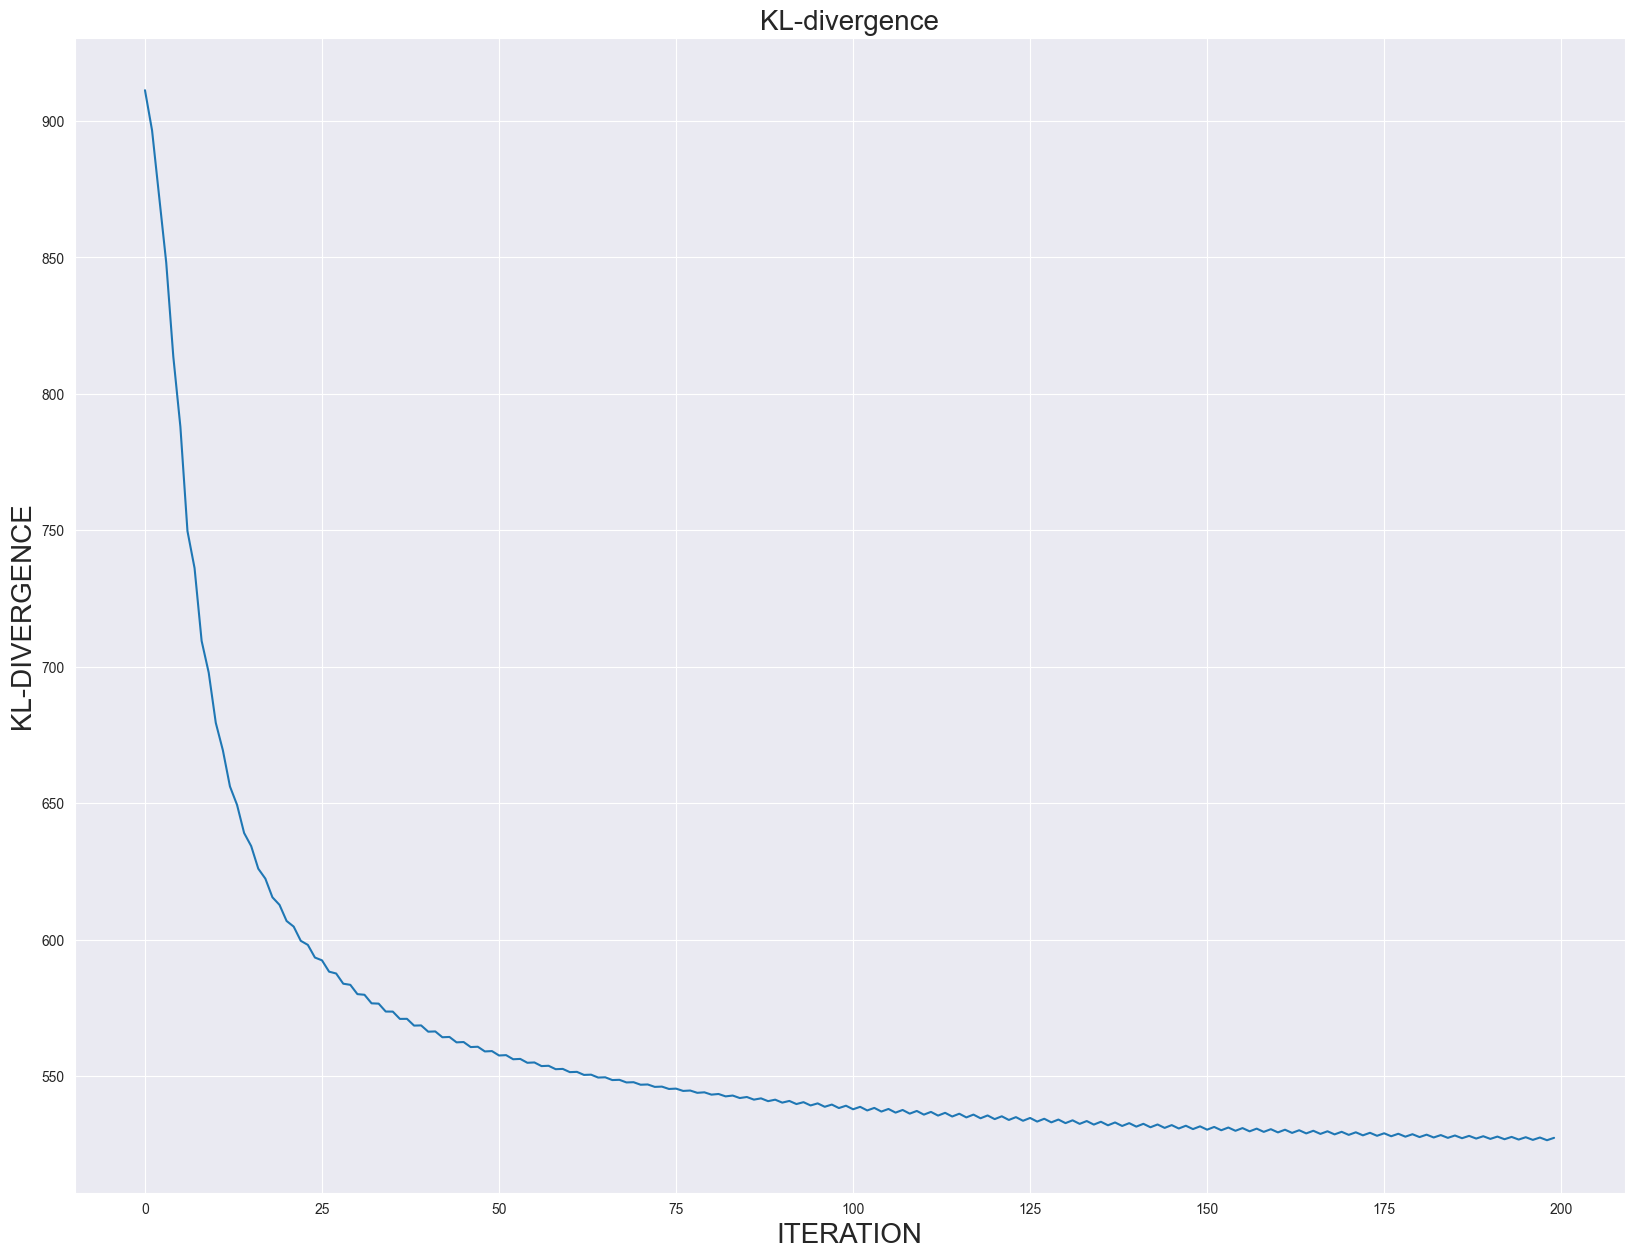

In [85]:
plt.figure(figsize=(20,15))
plt.plot(KL_array)
plt.title("KL-divergence", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("KL-DIVERGENCE", fontsize = 20)
plt.show()

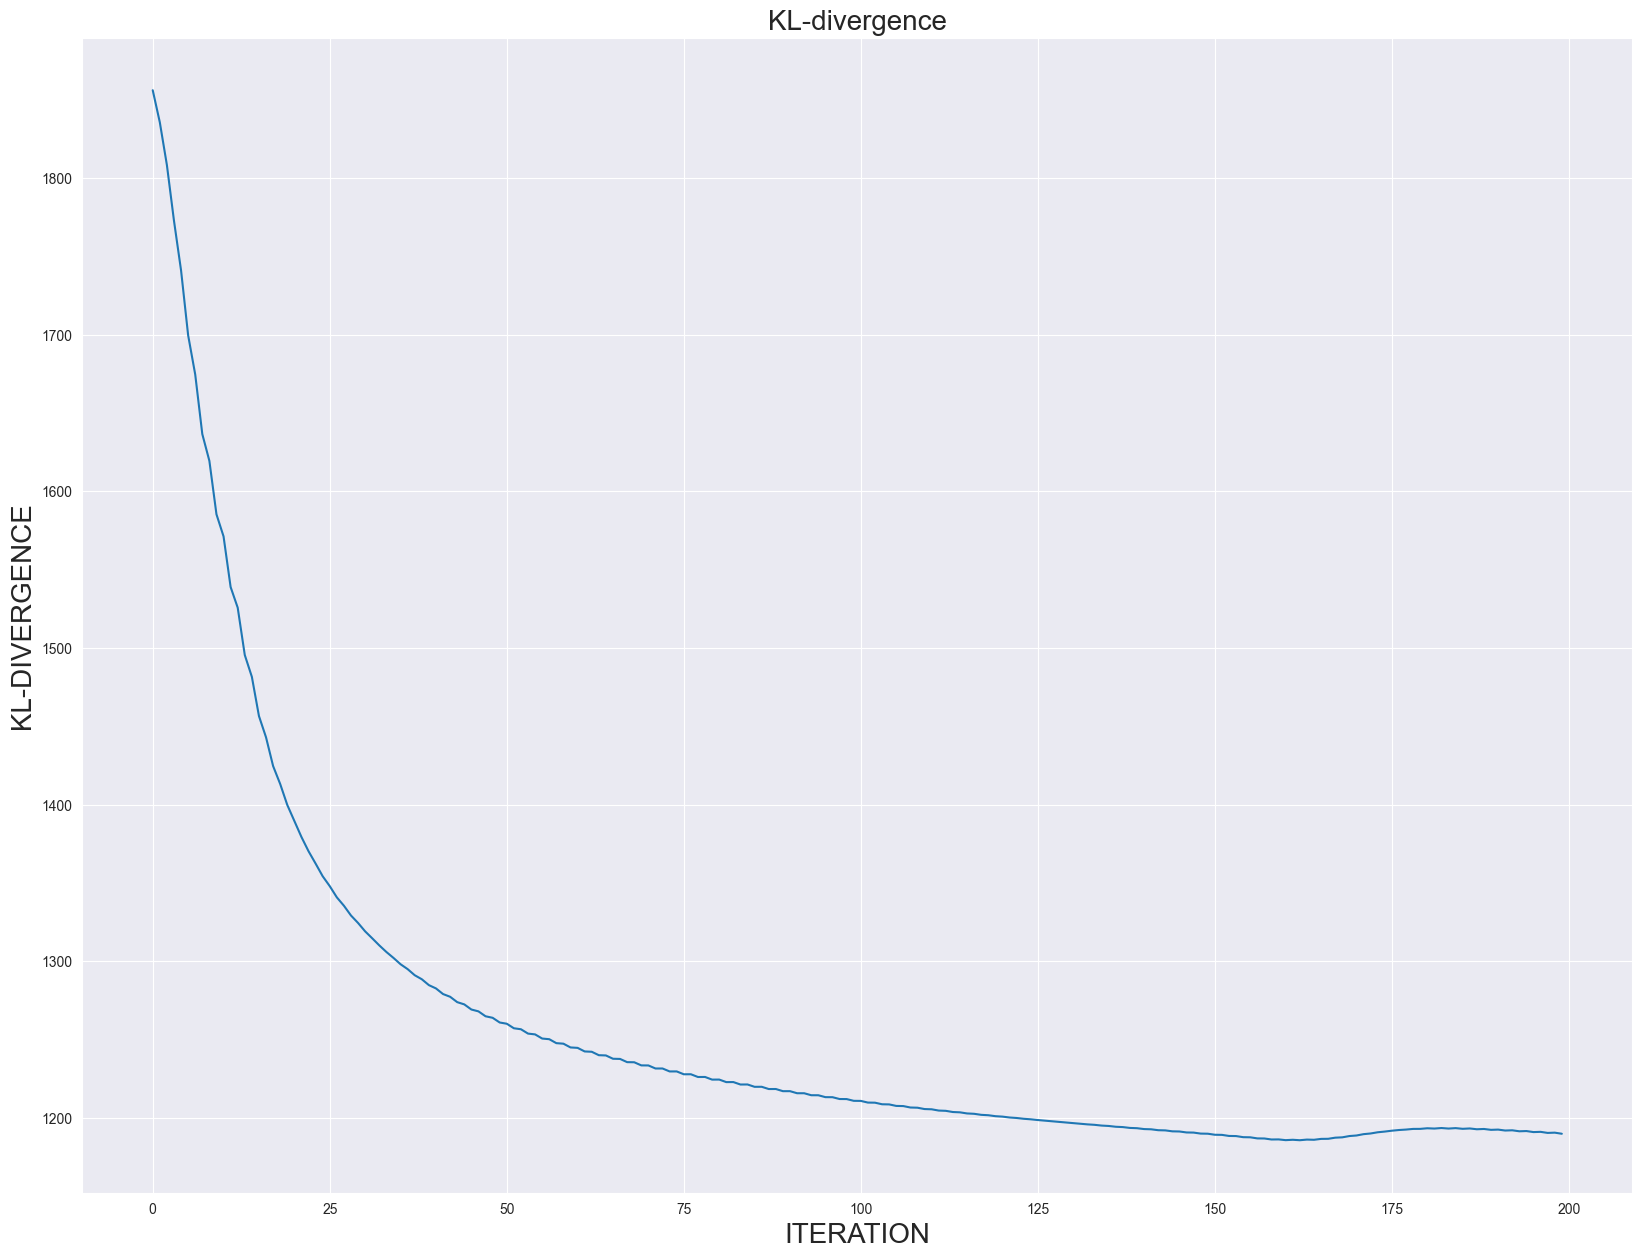

In [87]:
plt.figure(figsize=(20,15))
plt.plot(KL_array_non)
plt.title("KL-divergence", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("KL-DIVERGENCE", fontsize = 20)
plt.show()

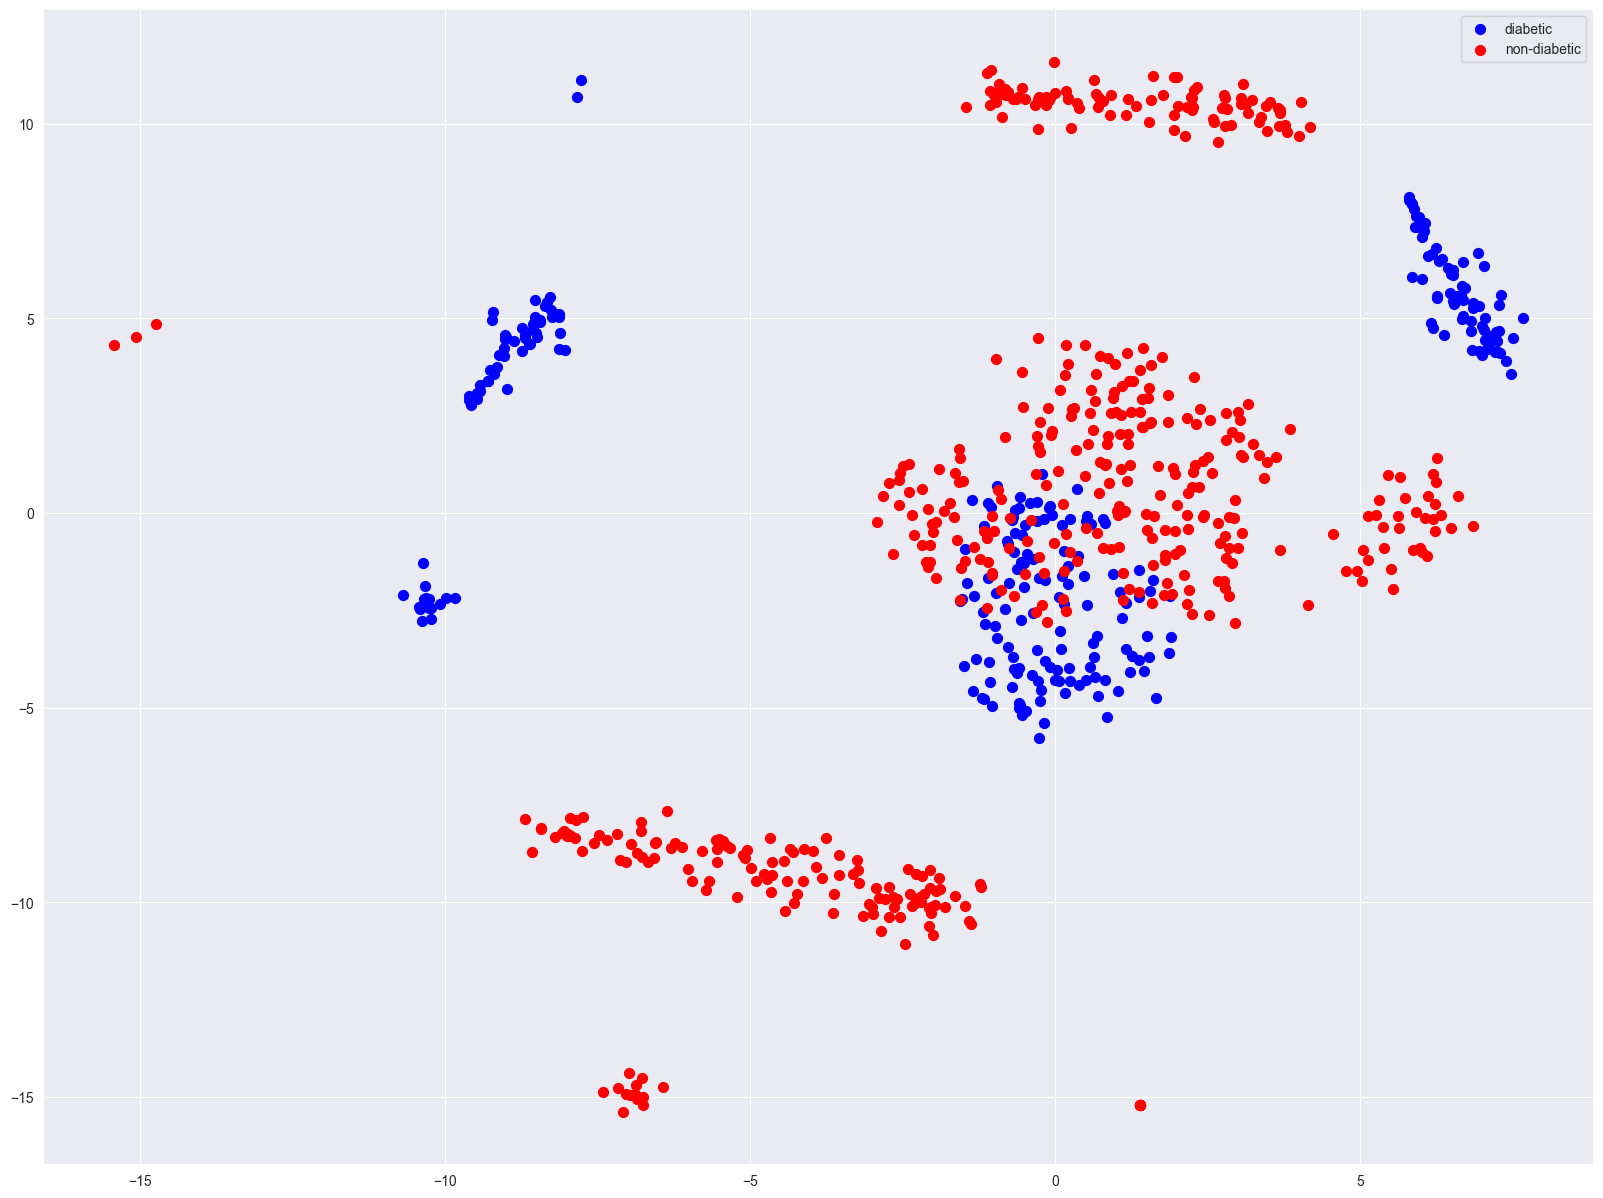

In [91]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c='b', s = 50, label='diabetic')
plt.scatter(y_non[:,0], y_non[:,1], c='r', s = 50, label='non-diabetic')
plt.legend()
plt.show()

In [92]:
import umap

/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shin/umap_testing/pythonProject1/.venv/lib/python3.13/site-packages/sklea

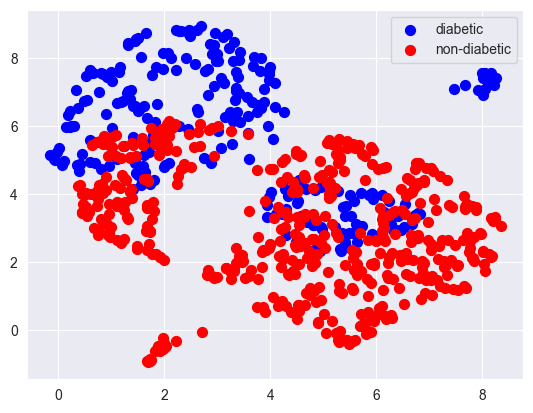

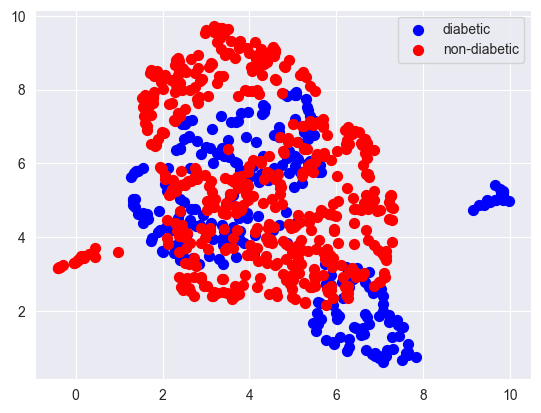

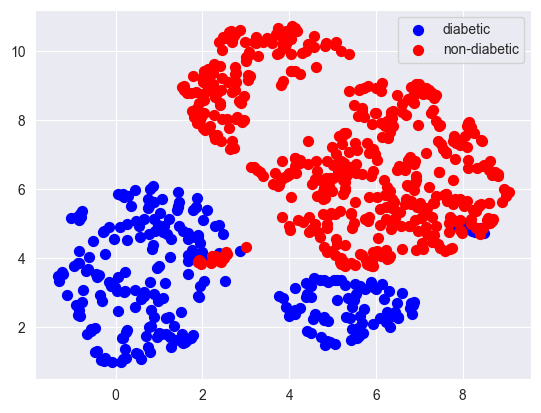

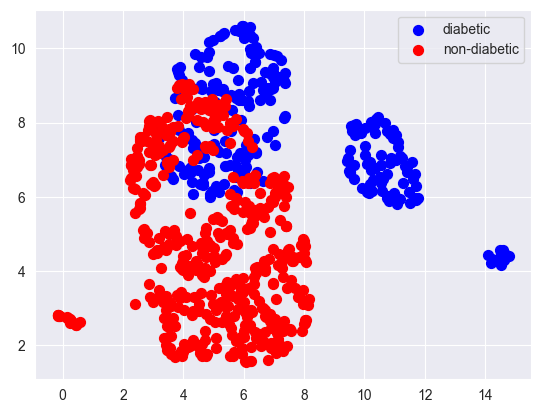

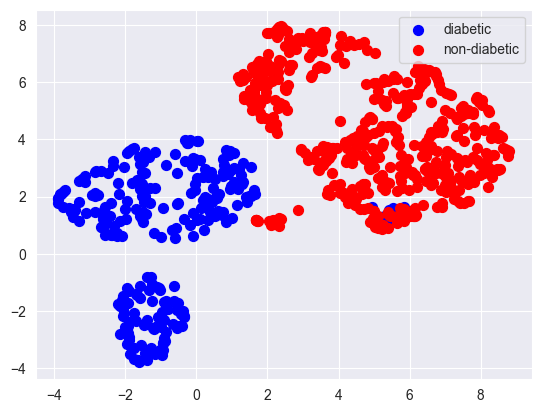

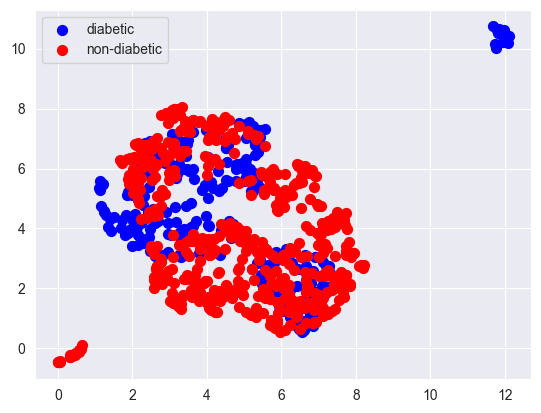

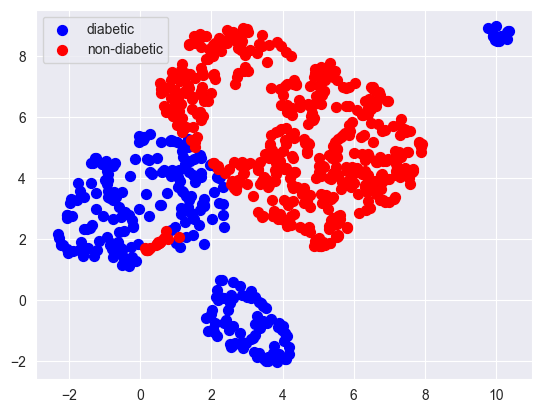

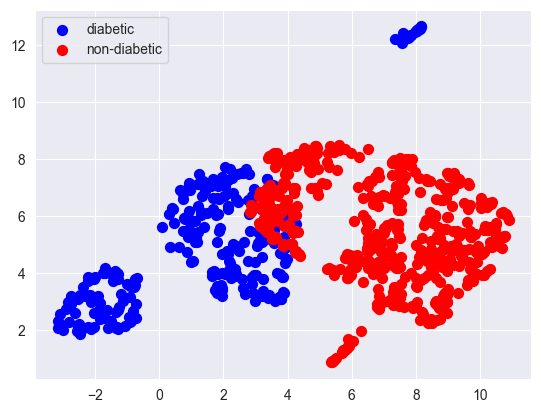

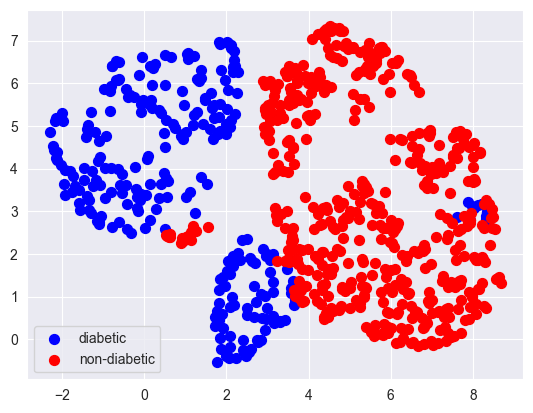

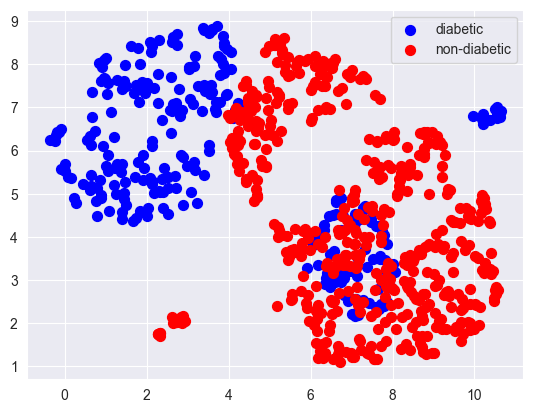

In [96]:
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP()
scaled_dia_data = StandardScaler().fit_transform(diabetic.values[:-1])
scaled_non_data = StandardScaler().fit_transform(non_diabetic.values[:-1])
embeddings = [reducer.fit_transform(scaled_dia_data) for _ in range(10)]
embeddings_non = [reducer.fit_transform(scaled_non_data) for _ in range(10)]
for i in range(len(embeddings)):
    plt.scatter(
    embeddings[i][:, 0],
    embeddings[i][:, 1], c='b', s = 50, label='diabetic')
    plt.scatter(
    embeddings_non[i][:, 0],
    embeddings_non[i][:, 1], c='r', s = 50, label='non-diabetic')
    plt.legend()
    plt.show()